In [28]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import math

# 读取图像
image_path = 'maze_photos\maze_2.jpg' # 请替换为你的图像路径
image = cv2.imread(image_path)


# 获取图像尺寸
height, width, _ = image.shape

# 根据需要修剪图像以确保宽度和高度为偶数
if height % 2 != 0:
    height -= 1

if width % 2 != 0:
    width -= 1

# 修剪图像
image = image[:height, :width]

print(image.shape)



(2160, 3840, 3)


In [29]:

gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

# #定义每个图层的像素范围大小
# layer_interval = 256 // 8

# layers = []

# for i in range(8):
#     # 创建一个空的黑色图像
#     layer = np.zeros_like(gray)
    
#     # 使用一个布尔掩码来提取特定范围的像素
#     mask = ((gray >= i*layer_interval) & (gray < (i+1)*layer_interval))
#     layer[mask] = gray[mask]
    
#     layers.append(layer)

# # 显示每个图层
# for idx, layer in enumerate(layers, start=1):
#     plt.subplot(2, 4, idx)
#     plt.imshow(layer, cmap='gray')
#     cv2.imwrite(f"layer{idx}.jpg",layer)
#     plt.axis('off')
#     plt.title(f'Layer {idx}')

# plt.tight_layout()
# plt.show()







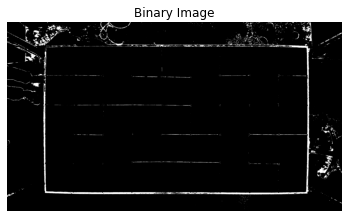

In [30]:
# 转换到HSV色彩空间
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

# 定义HSV中的颜色范围 (例如, 为了分离绿色)
lower_bound = (90, 50, 50)
upper_bound = (140, 100, 120)


# 使用inRange函数进行二值化
mask_1 = cv2.inRange(hsv_image, lower_bound, upper_bound)

# 使用plt显示图像
plt.imshow(mask_1, cmap='gray')
cv2.imwrite("mask_1.jpg",mask_1)
plt.title('Binary Image')
plt.axis('off')
plt.show()

2570


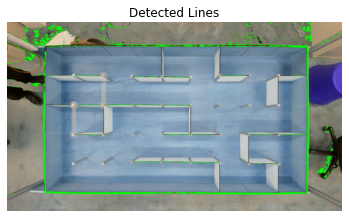

In [31]:
#找直线

# 使用Hough变换检测直线
lines = cv2.HoughLinesP(mask_1, 1, np.pi/180, threshold=100, minLineLength=10, maxLineGap=5)

# print(lines.squeeze())

print(len(lines))

# 创建一个用于显示的图像拷贝
output_image = image.copy()

# 在图像上绘制检测到的直线
for line in lines:
    x1, y1, x2, y2 = line[0]
    cv2.line(output_image, (x1, y1), (x2, y2), (0,255,0), 2)

# 使用matplotlib显示结果
plt.imshow(output_image, cmap='gray')
cv2.imwrite("color.jpg",output_image)
plt.title('Detected Lines')
plt.axis('off')
plt.show()








In [32]:
def find_boundary_lines(image_path):
    def draw_vertical_line(img, x, region):
        y_start, y_end = region[0], region[1]
        cv2.line(img, (x, y_start), (x, y_end), (255, 0, 0), 20)

    def draw_horizontal_line(img, y, region):
        x_start, x_end = region[2], region[3]
        cv2.line(img, (x_start, y), (x_end, y), (255, 0, 0), 20)

    # 读取图像
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # 获取图像的宽度和高度
    h, w = image_rgb.shape[:2]

    # 定义区域
    quarter_width = w // 6
    sixth_height = h // 4
    regions = {
        "top": (0, sixth_height, w // 2 - quarter_width // 2, w // 2 + quarter_width // 2),
        "bottom": (h - sixth_height, h, w // 2 - quarter_width // 2, w // 2 + quarter_width // 2),
        "left": (h // 2 - sixth_height // 2, h // 2 + sixth_height // 2, 0, quarter_width),
        "right": (h // 2 - sixth_height // 2, h // 2 + sixth_height // 2, w - quarter_width, w)
    }

    green = [0, 255, 0]

    lines = []

    for region_name, region in regions.items():
        y_start, y_end, x_start, x_end = region
        sub_img = image_rgb[y_start:y_end, x_start:x_end]

        mask = np.all(sub_img == green, axis=-1)
        y_coords, x_coords = np.where(mask)

        if len(x_coords) > 0 and region_name in ["left", "right"]:
            avg_x = int(np.mean(x_coords)) + x_start  # 添加x_start以将坐标转换回原图
            lines.append(((avg_x, y_start), (avg_x, y_end)))
        elif len(y_coords) > 0 and region_name in ["top", "bottom"]:
            avg_y = int(np.mean(y_coords)) + y_start  # 添加y_start以将坐标转换回原图
            lines.append(((x_start, avg_y), (x_end, avg_y)))

    return lines

In [33]:
# 调用函数
lines = find_boundary_lines('color.jpg')
print(lines)

[((1600, 267), (2240, 267)), ((1600, 1953), (2240, 1953)), ((427, 810), (427, 1350)), ((3459, 810), (3459, 1350))]


In [34]:
def get_rectangle_corners(lines):
    def intersection_point(x1, y1, x2, y2, x3, y3, x4, y4):
        """计算两条线段的交点"""
        px = ((x1*y2 - y1*x2)*(x3-x4) - (x1-x2)*(x3*y4 - y3*x4)) / ((x1-x2)*(y3-y4) - (y1-y2)*(x3-x4))
        py = ((x1*y2 - y1*x2)*(y3-y4) - (y1-y2)*(x3*y4 - y3*x4)) / ((x1-x2)*(y3-y4) - (y1-y2)*(x3-x4))
        return [int(px), int(py)]

    # 按斜率分类线段
    vertical_lines = [line for line in lines if line[0][0] == line[1][0]]  # 垂直线
    horizontal_lines = [line for line in lines if line[0][1] == line[1][1]]  # 水平线

    # 计算交点
    top_left = intersection_point(*vertical_lines[0][0], *vertical_lines[0][1], *horizontal_lines[0][0], *horizontal_lines[0][1])
    top_right = intersection_point(*vertical_lines[1][0], *vertical_lines[1][1], *horizontal_lines[0][0], *horizontal_lines[0][1])
    bottom_left = intersection_point(*vertical_lines[0][0], *vertical_lines[0][1], *horizontal_lines[1][0], *horizontal_lines[1][1])
    bottom_right = intersection_point(*vertical_lines[1][0], *vertical_lines[1][1], *horizontal_lines[1][0], *horizontal_lines[1][1])

    return [top_left, top_right, bottom_right, bottom_left]

In [35]:
corners = get_rectangle_corners(lines)
print(corners)
print(corners[0])

[[427, 267], [3459, 267], [3459, 1953], [427, 1953]]
[427, 267]


In [36]:
def perspective_change (image, top_left, top_right, bottom_right, bottom_left):
    img_bgr = image 
    pts1 = np.float32([top_left, top_right, bottom_left, bottom_right]) 
    pts2 = np.float32([[0,0],[2500,0],[0,1550],[2500,1550]]) 
    H = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img_bgr, H, (2500,1500))
    plt.imshow(dst)
    print(img_bgr.shape)
    return dst

(2160, 3840, 3)


True

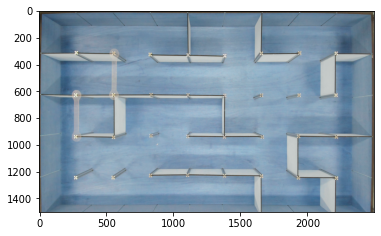

In [37]:
img_prs_1 = perspective_change(image,corners[0], corners[1], corners[2], corners[3])

cv2.imwrite('transformed_test.jpg', img_prs_1)

(1500, 2500)


True

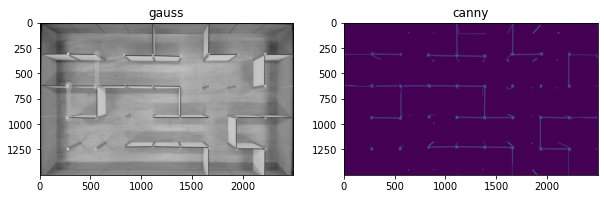

In [38]:
#读取图像
image = cv2.imread('transformed_test.jpg')
# cv2.imshow('image',image)
 
fig, axs = plt.subplots(1, 2, figsize=(10, 10))    
    
orig = image.copy()
# plt.subplot(2,2,1)
# plt.title("orig")
# plt.imshow(orig)

 
#图像预处理
gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
# print(gray.shape)
# plt.subplot(2,2,2)
# plt.title("gray")
# plt.imshow(gray, cmap='gray')
# cv2.imwrite("gray1.jpg", gray)

gauss = cv2.GaussianBlur(gray,(5,5),0)
print(gauss.shape)
plt.subplot(1,2,1)
plt.title("gauss")
plt.imshow(gauss, cmap='gray')

cv2.imwrite('gauss.jpg', gauss)

# ret, binary_image = cv2.threshold(gauss, 50, 255, cv2.THRESH_BINARY)
# print(ret)

# cv2.imwrite('binary_image.jpg', binary_image)



img_canny = cv2.Canny(gauss,120,210)
plt.subplot(1,2,2)
plt.title("canny")
plt.imshow(img_canny)
cv2.imwrite('canny_image.jpg', img_canny)

# 定义一个结构元素
kernel_size = 3  # 可以调整此大小，根据您希望的线条粗细进行调整
kernel = np.ones((kernel_size, kernel_size), np.uint8)

# 使用膨胀操作加粗线条
img_canny = cv2.dilate(img_canny, kernel, iterations=1)
cv2.imwrite('canny_image_denoised.jpg', img_canny)

In [39]:

result_y = np.zeros((5,9))

#Y detection


def Y_detect(image,result):
    
    img_rgb = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    print(image.shape)
    x_len = int(image.shape[0]/5)
#     print(x_len)
    y_len = int(image.shape[1]/9)
#     print(y_len)
    
    x_cord = 10
    y_cord = 0
    i = 1
    for m in range(5):
        for n in range(8):
            x_start = x_cord+m*x_len +30
            x_end = x_cord + (m+1)*x_len - 30
            y_start = int(y_cord+(n+1)*y_len)-50
            y_end = int(y_cord+(n+1)*y_len)+51
            
            if(m==4):
                x_start = x_cord+m*x_len +40
                x_end = x_cord + (m+1)*x_len - 40
            
#             print(x_start,x_end,y_start,y_end)
#             plt.imshow(img_rgb)
#             plt.plot([x_start, y_start], [x_start, y_end], color='green', linewidth=2)
#             plt.plot([x_start, y_start], [x_end, y_start], color='green', linewidth=2)
#             plt.plot([y_start, y_end], [x_end, y_end], color='green', linewidth=2)
#             plt.plot([x_end, y_start], [x_end, y_end], color='green', linewidth=2)
            
#             cv2.line(image, (x_start, y_start), (x_start, y_end), (0, 255, 0), 20)
#             cv2.line(image, (x_start, y_start), (x_end, y_start), (0, 255, 0), 20)
#             cv2.line(image, (y_start, y_end), (x_end, y_end), (0, 255, 0), 20)
#             cv2.line(image, (x_end, y_start), (x_end, y_end), (0, 255, 0), 20)
            
            
            
            
            roi = image[x_start:x_end,y_start:y_end]
#             print(roi.shape)

            
            count = np.sum(roi==255)
            print(i,count)
            i = i + 1
            if(count>=700):
                result_y[m][n] = 1
#     plt.imshow(img_rgb)
#     plt.show()
    
Y_detect(img_canny,result_y)
np.savetxt('array_y.txt', result_y, fmt='%d', delimiter=' ')
    
    

(1500, 2500)
1 0
2 0
3 20
4 1811
5 247
6 1793
7 414
8 0
9 106
10 0
11 132
12 288
13 429
14 283
15 105
16 1418
17 46
18 1324
19 78
20 131
21 1752
22 226
23 41
24 51
25 305
26 456
27 159
28 202
29 493
30 385
31 1632
32 464
33 167
34 171
35 34
36 53
37 59
38 1084
39 204
40 901


In [40]:

result_x = np.zeros((5,9))

#X detection


def X_detect(image,result):
#     print(image.shape)
    x_len = int(image.shape[0]/5)
#     print(x_len)
    y_len = image.shape[1]/9
#     print(y_len)
    
    x_cord = 0
    y_cord = 0
    i =1 
    for m in range(4):
        for n in range(9):
            x_start = int(x_cord+(m+1)*x_len)-50
            x_end = int(x_cord+(m+1)*x_len)+61
            y_start = int(y_cord+(n)*y_len)+30
            y_end = int(y_cord+(n+1)*y_len)-30
            
#             print(x_start,x_end,y_start,y_end)
            
            roi = image[x_start:x_end,y_start:y_end]
#             print(roi.shape)

            
            count = np.sum(roi==255)
            print(i, count)
            i = i+1
            if(count>=500):
                result_x[m][n] = 1
    
    
X_detect(img_canny,result_x)
np.savetxt('array_x.txt', result_x, fmt='%d', delimiter=' ')
    
    

1 682
2 1532
3 0
4 1328
5 1326
6 178
7 1396
8 0
9 675
10 957
11 1331
12 1349
13 1330
14 1323
15 197
16 79
17 75
18 0
19 0
20 1339
21 84
22 137
23 1322
24 1544
25 82
26 1401
27 1064
28 0
29 0
30 0
31 1569
32 1324
33 1627
34 115
35 1721
36 0


In [41]:
#transfer to ASCII
def get_result(result_x, result_y):
    Heng = "---"
    Shu = "  |"
    Kong = "   "

    result = [
        ["",Heng, Heng ,Heng ,Heng, Heng ,Heng ,Heng ,Heng ,Heng ,""],
        ["|",Kong,Kong,Kong,Kong,Kong,Kong,Kong,Kong," ","|"],
        ["",Kong,Kong,Kong,Kong,Kong,Kong,Kong,Kong,Kong,""],
        ["|",Kong,Kong,Kong,Kong,Kong,Kong,Kong,Kong," ","|"],
        ["",Kong,Kong,Kong,Kong,Kong,Kong,Kong,Kong,Kong,""],
        ["|",Kong,Kong,Kong,Kong,Kong,Kong,Kong,Kong," ","|"],
        ["",Kong,Kong,Kong,Kong,Kong,Kong,Kong,Kong,Kong,""],
        ["|",Kong,Kong,Kong,Kong,Kong,Kong,Kong,Kong," ","|"],
        ["",Kong,Kong,Kong,Kong,Kong,Kong,Kong,Kong,Kong,""],
        ["|",Kong,Kong,Kong,Kong,Kong,Kong,Kong,Kong," ","|"],
        ["",Heng, Heng ,Heng ,Heng, Heng ,Heng ,Heng ,Heng ,Heng ,""]

    ]
    # read result_x
    for m in range(4):
        for n in range(9):
            if(result_x[m][n] == 1):
                result[2*m+2][n+1] = Heng 

    #read result_y
    for m in range(5):
        for n in range(8):
            if(result_y[m][n] == 1):
                result[2*m+1][n+1] = Shu
    
    return result
    

    
test = get_result(result_x,result_y)
# 打印数组
for row in test:
    for col in row:
        print(col, end=' ')
    print()  # 换行

 --- --- --- --- --- --- --- --- ---  
|               |       |           | 
 --- ---     --- ---     ---     ---  
|                               |   | 
 --- --- --- --- ---                  
|       |           |               | 
     ---         --- ---     --- ---  
|                           |       | 
             --- --- ---     ---      
|                       |       |   | 
 --- --- --- --- --- --- --- --- ---  


In [42]:
# #斜率
# def calculate_slope(line):
#     x1, y1, x2, y2 = line
#     if x2 - x1 == 0:  # Avoid division by zero
#         return float('inf')
#     return (y2 - y1) / (x2 - x1)

In [43]:
# #是否平行
# def are_parallel(slope1, slope2):
#     if slope1 == float('inf') and slope2 == float('inf'):
#         return True
#     if abs(slope1 - slope2) < 0.1:  # Tolerance
#         return True
#     return False
# #是否垂直
# def are_perpendicular(slope1, slope2):
#     if slope1 == float('inf'):
#         return abs(slope2) < 0.1
#     if slope2 == float('inf'):
#         return abs(slope1) < 0.1
#     return abs(slope1 * slope2 + 1) < 0.1

In [44]:
# #直线检测

# # 使用Canny边缘检测
# edges = cv2.Canny(gray, 50, 150, apertureSize=3)

# # 使用Hough变换检测直线
# lines = cv2.HoughLinesP(edges, 1, np.pi/180, threshold=100, minLineLength=10, maxLineGap=10)

# # 创建一个空白的二值图像
# binary_output = np.zeros_like(gray)

# # 在二值图像上绘制检测到的直线
# for line in lines:
#     x1, y1, x2, y2 = line[0]
#     cv2.line(binary_output, (x1, y1), (x2, y2), 255, 2)

# # 使用plt显示图像
# plt.imshow(binary_output, cmap='gray')
# cv2.imwrite("line.jpg",binary_output )
# plt.title('Detected Lines')
# plt.axis('off')
# plt.show()






In [45]:
# # 读取图像
# image_path = 'edges.jpg' # 请替换为你的图像路径
# image_2 = cv2.imread(image_path)

# # 使用Canny边缘检测来找到图像中的边缘
# edges_2 = cv2.Canny(image_2, 50, 150)

# cv2.imwrite("2edge.jpg",edges_2)

# # 查找轮廓
# contours, _ = cv2.findContours(edges_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # # 在原图上画出轮廓
# # cv2.drawContours(image, contours, -1, (0, 255, 0), 2)

# # # 使用plt显示图像
# # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# # cv2.imwrite("contours.jpg", image)
# # plt.title('Contours')
# # plt.axis('off') # 隐藏坐标轴
# # plt.show()

# # 根据面积找到最大的轮廓
# max_contour = max(contours, key=cv2.contourArea)


# # 获取拟合矩形的坐标
# x, y, w, h = cv2.boundingRect(max_contour)

# print(x,y,w,h)

# # 画出这个矩形
# # rect_image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)  # 将灰度图转换为BGR
# cv2.rectangle(image, (x, y), (x+w, y+h), (0, 255, 0), 2)

# # 使用plt显示图像
# # plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
# plt.imshow(image)
# cv2.imwrite("contour.jpg",image)
# plt.title('Bounding Rectangle')
# plt.axis('off')
# plt.show()


# # # 创建一个全黑的背景
# # output = np.zeros_like(image)

# # # 在全黑背景上只画出最大的轮廓
# # cv2.drawContours(output, [max_contour], -1, (0,255,0), thickness=cv2.FILLED)

# # # 使用plt显示图像
# # plt.imshow(output, cmap='gray')
# # cv2.imwrite("contour.jpg",output)
# # plt.title('Largest Contour')
# # plt.axis('off')
# # plt.show()








